In [37]:
# Snowflake Imports
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import udf
from snowflake.ml.modeling.metrics import *

# Other imports
from getpass import getpass
import seaborn as sns

# Reading Snowflake Connection Details
sf_connection = {
    "account": "your-account",
    "user": getpass(),
    "password": getpass(),
    "role": "ACCOUNTADMIN",
    "warehouse": "COMPUTE_WH"
}

# Creating Snowpark Session
session = Session.builder.configs(sf_connection).create()

# Create a fresh & new database
session.sql('CREATE OR REPLACE DATABASE CHATGPT_DEMO').collect()
session.use_schema('CHATGPT_DEMO.PUBLIC')
session.sql('CREATE OR REPLACE STAGE FUNCTIONS').collect()

[Row(status='Stage area FUNCTIONS successfully created.')]

## Load Data

In [38]:
import pandas as pd
df = pd.read_csv('news_headlines.csv', sep=';')

snow_df = session.write_pandas(df=df, table_name='NEWS_CATEGORIES_DATASET', overwrite=True)
snow_df.show(5)

# get categories of dataset
possible_categories = json.loads(snow_df[['CATEGORY']].distinct().select(F.array_agg('CATEGORY').as_('CATEGORIES')).collect()[0]['CATEGORIES'])
print(possible_categories)

-------------------------------------------------------------------
|"HEADLINE"                                          |"CATEGORY"  |
-------------------------------------------------------------------
|U.S. Healthcare Website Down Overnight For Upgrade  |BUSINESS    |
|A Race Against Time                                 |BUSINESS    |
|Law School Sends Acceptance Emails To Thousands...  |COLLEGE     |
|Another University Stops Students From Passing ...  |COLLEGE     |
|'We Don't Talk Anymore': A Chatty Playlist for ...  |COMEDY      |
-------------------------------------------------------------------

['BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'ENTERTAINMENT', 'HEALTHY LIVING', 'SCIENCE', 'STYLE & BEAUTY', 'TECH', 'TRAVEL', 'WELLNESS', 'WORLD NEWS', 'POLITICS', 'SPORTS']


## Create OpenAI Authentication

In [39]:
# Create network role
session.sql("""CREATE OR REPLACE NETWORK RULE OPENAI_API_NETWORK_RULE
                    MODE = EGRESS
                    TYPE = HOST_PORT
                    VALUE_LIST = ('api.openai.com')""").collect()

# Create secret with OpenAI Key
session.sql("""CREATE OR REPLACE SECRET OPENAI_API_KEY
                    TYPE = GENERIC_STRING
                    SECRET_STRING = '<your-openai-key>'""").collect()

# Create external access integration
session.sql("""CREATE OR REPLACE EXTERNAL ACCESS INTEGRATION OPENAI_API_EXT_INT
                    ALLOWED_NETWORK_RULES = (OPENAI_API_NETWORK_RULE)
                    ALLOWED_AUTHENTICATION_SECRETS = (OPENAI_API_KEY)
                    ENABLED = true""").collect()

[Row(status='Integration OPENAI_API_EXT_INT successfully created.')]

## Run ChatGPT

In [40]:
# scikit-llm will be automatically uploaded to Snowflake
session.custom_package_usage_config = {
    "enabled": True,
    "cache_path": "@FUNCTIONS"
}

In [42]:
# UDF to perform multi-class classification with ChatGPT
@udf(name='chatgpt_classify',
     is_permanent=True,
     stage_location='@FUNCTIONS', 
     replace=True,
     packages=['openai','scikit-llm'], 
     session=session)
def chatgpt_classify(text: str, possible_categories: list) -> str:
    import _snowflake
    from skllm.config import SKLLMConfig
    from skllm import ZeroShotGPTClassifier
    SKLLMConfig.set_openai_key(_snowflake.get_generic_secret_string('CRED'))
    clf = ZeroShotGPTClassifier()
    clf.fit(None, possible_categories)
    return clf.predict([text])[0]

# SQL required until PuPr of External Access and availability in Snowpark-API
session.sql("""ALTER FUNCTION chatgpt_classify(VARCHAR, ARRAY) SET SECRETS = ('CRED' = OPENAI_API_KEY)""").collect()
session.sql("""ALTER FUNCTION chatgpt_classify(VARCHAR, ARRAY) SET EXTERNAL_ACCESS_INTEGRATIONS = (OPENAI_API_EXT_INT)""").collect()

The version of package 'openai' in the local environment is 0.27.9, which does not fit the criteria for the requirement 'openai'. Your UDF might not work when the package version is different between the server and your local environment.
The following packages are not available in Snowflake: ['scikit-llm'].
Unable to load environments from remote path @FUNCTIONS, creating a fresh environment instead.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
snowflake-ml-python 1.0.5 requires pandas<2,>=1.0.0, but you have pandas 2.0.3 which is incompatible.
snowflake-ml-python 1.0.5 requires scikit-learn<1.3,>=1.2.1, but you have scikit-learn 1.3.0 which is incompatible.

Package multidict(version 6.0.4) contains native code, switching to latest available version in Snowflake '6.0.2' instead.
Package scipy(version 1.11.2) contains native code, switching to latest availa

[Row(status='Statement executed successfully.')]

In [43]:
classifications_df = snow_df.with_column('PRED', chatgpt_classify(F.col('HEADLINE'), F.lit(possible_categories)))
classifications_df.write.save_as_table('MY_CLASSIFICATIONS', mode='overwrite')

In [44]:
classifications_df = session.table('MY_CLASSIFICATIONS')
classifications_df.show()

-----------------------------------------------------------------------------------
|"HEADLINE"                                          |"CATEGORY"  |"PRED"         |
-----------------------------------------------------------------------------------
|U.S. Healthcare Website Down Overnight For Upgrade  |BUSINESS    |TECH           |
|A Race Against Time                                 |BUSINESS    |SPORTS         |
|Law School Sends Acceptance Emails To Thousands...  |COLLEGE     |COLLEGE        |
|Another University Stops Students From Passing ...  |COLLEGE     |COLLEGE        |
|'We Don't Talk Anymore': A Chatty Playlist for ...  |COMEDY      |ENTERTAINMENT  |
|The Totally Real Transcript Of Kim Davis' Meeti...  |COMEDY      |POLITICS       |
|Stephen Colbert Has Beef With American Eagle Ou...  |COMEDY      |ENTERTAINMENT  |
|Arrest Made After Missing Teen's Body Found Dec...  |CRIME       |CRIME          |
|Even Prison Officials Want To Curb Solitary Con...  |CRIME       |CRIME    

Acccuracy: 0.637681


The version of package 'snowflake-snowpark-python' in the local environment is 1.6.1, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
/Users/mgorkow/opt/anaconda3/envs/pysnowparkxxx/lib/python3.9/site-packages/snowflake/ml/modeling/metrics/classification.py:703: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn(warning.message, category=warning.category)


Precision: 0.7019323671497585


The version of package 'snowflake-snowpark-python' in the local environment is 1.6.1, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


Recall: 0.6376811594202898


The version of package 'snowflake-snowpark-python' in the local environment is 1.6.1, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


F1: 0.6233983975671955


<Axes: >

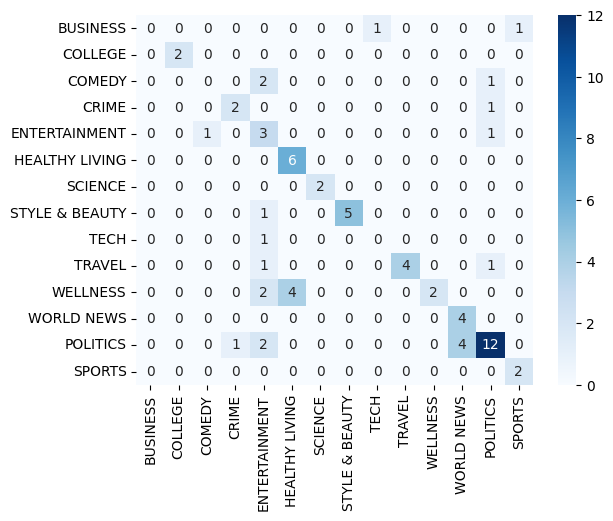

In [45]:
print('Acccuracy:', accuracy_score(df=classifications_df, y_true_col_names='CATEGORY', y_pred_col_names='PRED'))
print('Precision:', precision_score(df=classifications_df, y_true_col_names='CATEGORY', y_pred_col_names='PRED', average='weighted'))
print('Recall:', recall_score(df=classifications_df, y_true_col_names='CATEGORY', y_pred_col_names='PRED', average='weighted'))
print('F1:', f1_score(df=classifications_df, y_true_col_names='CATEGORY', y_pred_col_names='PRED', average='weighted'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=classifications_df, y_true_col_name='CATEGORY', y_pred_col_name='PRED', labels=possible_categories)
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=possible_categories, yticklabels=possible_categories)